In [169]:
import os
import plotting
import register
import PIL
import numpy as np
import  utils
import utils_hyper
import matplotlib.pyplot as plt
import scipy.ndimage.measurements as spm
%matplotlib inline

plt.ion() # set interactive matplotlib
plt.rcParams["image.cmap"] = "gist_gray"

In [131]:
# -- get file names for broadband and hsi
# droot  = os.environ["green-projects/project-uo_rebound/workspace/share/data"]
bbname = os.path.join("/green-projects/project-uo_rebound/workspace/share/data", "bb", "2017", "07", "06", "stack_bb_0037777.raw")
hsname = os.path.join("/green-projects/project-uo_rebound/workspace/share/data", "slow_hsi_scans", "night_052617_00007.raw")


# -- read in the images
try:
    img_hs
except:
    img_bb = utils.read_raw(bbname)
    img_hs = utils_hyper.read_hyper(hsname).data[350].copy()

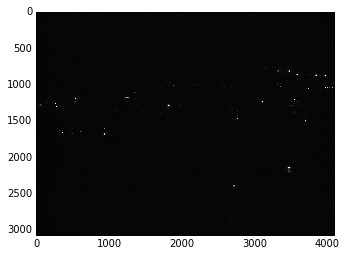

In [170]:
plt.imshow(img_bb)

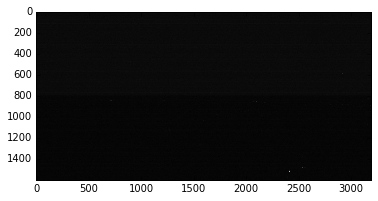

In [171]:
plt.imshow(img_hs)

In [134]:
img_hs.shape[1] / 2 / factor

320.85296637214861

In [97]:
import scipy.misc
img_newb = scipy.misc.imresize(img_bb, (617, 823))

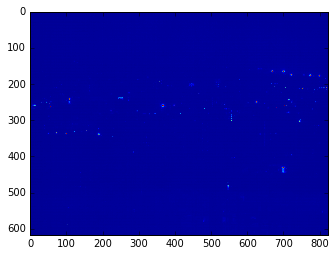

In [98]:
plt.imshow(img_newb)

### finding the scaling factor 

In [135]:
# sources in broadband
rr_bb = np.array([821.88822972243372, 884.4122688099369, 1212.2626788969724])
cc_bb = np.array([3313.3156852608604, 3962.6037834772392, 3543.3720854930834])

In [136]:
#sources in hyperspectral
rr_hsi = np.array([852.906, 863.483, 931.829])
cc_hsi = np.array([2065.47, 2194.84, 2112.66])

In [137]:
#distance between broadband sources 
dist_bb = np.sqrt((rr_bb[:, np.newaxis] - rr_bb)**2 + 
                (cc_bb[:,np.newaxis] - cc_bb)**2)

bb1 = dist_bb[0,1]
bb2 = dist_bb[0,2]
bb3 = dist_bb[1,2]
print (bb1, bb2, bb3)

(652.29156820340518, 453.12046726685526, 532.20400974524398)


In [138]:
#distance between hyperspectral sources 
dist_hsi = np.sqrt((rr_hsi[:, np.newaxis] - rr_hsi)**2 + 
                (cc_hsi[:,np.newaxis] - cc_hsi)**2)

hsi1 = dist_hsi[0, 1]
hsi2 = dist_hsi[0, 2]
hsi3 = dist_hsi[1, 2]
print (hsi1, hsi2, hsi3)

(129.80165572518746, 91.955076145909445, 106.88651980488488)


In [139]:
factor = ((bb1/hsi1) + (bb2/hsi2) + (bb3/hsi3)) / 3
factor

4.9773577537933162

In [140]:


# -- get average intensity of pixels across rgb channels
img_a = img_bb.astype(float)

# -- get medians and standard deviations of luminosity images
med = np.median(img_a)
sig = img_a.std()

# -- get the thresholded images
thr = img_a > (med + 4.0*sig)


In [141]:
# -- label the sources
labs = spm.label(thr)

# -- get the source sizes
lsz = spm.sum(thr, labs[0], range(1, labs[1]+1))

In [142]:
# -- get the positions of the sources
ind = (lsz > 200.) & (lsz < 1700.) 

# -- get center of masses for all the labelled sources in the image
rr1, cc1, = np.array(spm.center_of_mass(thr, labs[0], 
                                   np.arange(1, labs[1]+1)[ind])).T

In [143]:
#Extract the center of masses of sources above the threshold
# rr1, cc1 = register.locate_sources(img)
# rr1.shape

In [144]:
print rr1.shape
print cc1.shape

(21,)
(21,)


In [145]:
#Calculating distances between sources of image
dist = np.sqrt((rr1[:, np.newaxis] - rr1)**2 + (cc1[:,np.newaxis] - cc1)**2)
print dist.shape

(21, 21)


In [146]:
dist = (dist / factor)
print dist

[[   0.           31.22151036   23.36092502   74.52492726   99.64316964
   451.42520048  459.19076553  593.47413538   79.63496711  112.58288348
   595.37521543  345.57525684  692.43064086  315.30967305  648.51280896
   113.3806697   144.30221589  647.28197913  622.21320146  537.06505191
   351.64056641]
 [  31.22151036    0.           53.44841429  105.53054658  130.71290969
   420.69973569  428.44676273  562.55630215   90.95099588   95.12263038
   564.53003183  315.74130245  661.54318744  285.72359943  617.7006103
   121.52134396  157.00005232  617.27671445  592.33620763  507.70065162
   339.5286553 ]
 [  23.36092502   53.44841429    0.           52.40574442   77.63086419
   471.07803287  478.87964806  613.5274531    69.04934893  121.56943687
   615.24399421  363.7770635   712.38127842  333.20454924  668.28788443
   103.20898353  129.80436326  665.52206209  640.25857694  554.39609703
   353.04244995]
 [  74.52492726  105.53054658   52.40574442    0.           25.22657654
   522.845493 

In [147]:
def find(dist, dcat, buff=10):
    """
    Find potential sources ith the appropriate distance  ratios
    """
    
    # -- 
    src = np.arange(dist.shape[0])
    dcat   = dcat[dcat>0]
    for tdist in dcat:
        tind  = (np.abs(dist - tdist) < buff).any(1)
        dist = dist[tind]
        src = src[tind]
        if tdist == dcat[-1]:
            return src

def find_quads(dist, rr_cat, cc_cat):
    """
    Find quads of sources with the appropriate distance ratios.
    """

    # -- trim rows that do not have that distance distribution
    pts  = []

    # -- get all possible points
    allind = np.arange(dist.shape[0])
    
    dcat0 = np.sqrt(((rr_cat[0] - rr_cat)**2 + (cc_cat[0] - cc_cat)**2))
    dcat1 = np.sqrt(((rr_cat[1] - rr_cat)**2 + (cc_cat[1] - cc_cat)**2))
    dcat2 = np.sqrt(((rr_cat[2] - rr_cat)**2 + (cc_cat[2] - cc_cat)**2))
    
    p0ind = find(dist, dcat0)
    p1ind = find(dist, dcat1)
    p2ind = find(dist, dcat2)
    
    return p0ind, p1ind, p2ind
    

In [148]:
p0ind, p1ind, p2ind = find_quads(dist, rr_hsi, cc_hsi)
print p0ind
print p1ind
print p2ind

[ 1  3  4  7  9 10 15 19]
[ 1  2  3  4  6  7  9 10 11 15 19]
[ 0  1  3  4  7  8  9 10 12 15 17 19]


In [149]:
dcat0 = np.sqrt(((rr_hsi[0] - rr_hsi)**2 + (cc_hsi[0] - cc_hsi)**2))
dcat1 = np.sqrt(((rr_hsi[1] - rr_hsi)**2 + (cc_hsi[1] - cc_hsi)**2))
dcat2 = np.sqrt(((rr_hsi[2] - rr_hsi)**2 + (cc_hsi[2] - cc_hsi)**2))
good01 = []
for ii in p0ind:
    for jj in p1ind:
        if np.abs(dist[ii,jj] - dcat0[1]) < 10:
            good01.append([ii, jj])
good012 = []
for ii,jj in good01:
    for kk in p2ind:
        flag02 = np.abs(dist[ii, kk] - dcat0[2]) < 10
        flag12 = np.abs(dist[jj, kk] - dcat1[2]) < 10
        if flag02 and flag12:
            good012.append([ii, jj, kk])



In [150]:
good012 = np.array(good012)
# good012 = good012[(cc1[good012[:, 0]] - cc1[good012[:, 1]]) > 100]

In [151]:
good012

array([[ 1,  4,  8],
       [ 4, 15,  0],
       [ 7, 19, 17],
       [ 9,  2, 15]])

In [152]:
p0s, p1s, p2s = np.array(good012).T

# -- find the delta angles of the first 2 pairs
theta01 = np.arccos((rr1[p0s] - rr1[p1s]) / dist[p0s, p1s] * factor)
theta02 = np.arccos((rr1[p0s] - rr1[p2s]) / dist[p0s, p2s] * factor)
dtheta  = (theta01 - theta02) * 180. / np.pi

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in arccos
/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in arccos


In [153]:
dcatm = np.sqrt((rr_hsi[:, np.newaxis] - rr_hsi)**2 + 
                (cc_hsi[:,np.newaxis] - cc_hsi)**2)

In [154]:
# -- find the delta angle of thr first 2 sources of catalog
theta01_cat = np.arccos((rr_hsi[0] - rr_hsi[1]) / dcatm[0, 1])
theta02_cat = np.arccos((rr_hsi[0] - rr_hsi[2]) / dcatm[0, 2])
dtheta_cat  = (theta01_cat - theta02_cat) * 180. / np.pi

In [155]:
guess = np.array(good012[np.abs(dtheta - dtheta_cat).argmin()])
print guess

[1 4 8]


In [158]:
rrr0, ccc0 = rr_hsi[np.array([0, 1, 2])], cc_hsi[np.array([0, 1, 2])]
rrr1, ccc1 = rr1[guess], cc1[guess]

In [159]:
roff_hsi = img_hs.shape[0] / 2
coff_hsi = img_hs.shape[1] / 2
roff_bb  = img_bb.shape[0] / 2
coff_bb  = img_bb.shape[1] / 2

rrr0 -= roff_hsi
ccc0 -= coff_hsi
rrr1 -= roff_bb
ccc1 -= coff_bb

rrr1 /= factor
ccc1 /= factor

# -- get the matrix for catalog sources
mones      = np.zeros(rrr0.size * 2 + 1)
mones[::2] = 1.0

pm         = np.zeros([rrr0.size * 2, 4])
pm[::2,0]  = rrr0
pm[1::2,0] = ccc0
pm[::2,1]  = -ccc0
pm[1::2,1] = rrr0
pm[:,2]    = mones[:-1]
pm[:,3]    = mones[1:]

# -- get the matrix for image sources
bv         = np.zeros([rrr0.size * 2])
bv[::2]    = rrr1
bv[1::2]   = ccc1

# -- calculating rotation of image 
pmTpm = np.dot(pm.T, pm)
av    = np.dot(np.linalg.inv(pmTpm), np.dot(pm.T, bv))

dr, dc = av[-2:]
dtheta = np.arctan2(av[1], av[0]) * 180. / np.pi


In [160]:
print (dr, dc, dtheta)

(-204.64951903987821, -213.41882722547962, -0.95373982675788993)


In [75]:
print rr_hsi
print cc_hsi

print rr_bb
print cc_bb

[ 852.906  863.483  931.829]
[ 2065.47  2194.84  2112.66]
[  821.88822972   884.41226881  1212.2626789 ]
[ 3313.31568526  3962.60378348  3543.37208549]


In [161]:
#fixing centers of the two images
c1 = img_bb.shape[1] - cc_bb[0]
c1 = c1 / factor
c1 = cc_hsi[0] + c1

c2 = cc_bb[0] / factor
c2 = cc_hsi[0] - c2

r1 = img_bb.shape[0] - rr_bb[0]
r1 = r1 / factor
r1 = rr_hsi[0] + r1

r2 = rr_bb[0] / factor
r2 = rr_hsi[0] - r2

print (c1, c2, r1, r2)

(2222.7189568672543, 1399.7923756147052, 1304.9755279664644, 687.78059202705265)


In [162]:
#calculating center of broadband image
c_bbcenter = (c1- c2) / 2 + c2
r_bbcenter = (r1 - r2) / 2 + r2
print ("The center of broadband image in hyperspectral image :", (c_bbcenter, r_bbcenter))

#centers of hyperspectral
c_hsicenter = img_hs.shape[1] / 2
r_hsicenter = img_hs.shape[0] / 2
print ("the center of hyperspectral image:" , (c_hsicenter, r_hsicenter))

#distances between centers of both the images
c_dist = c_bbcenter - c_hsicenter
r_dist = r_bbcenter - r_hsicenter
print ("the distance between centers of  broadband and hyperspectral: ", (c_dist, r_dist))

('The center of broadband image in hyperspectral image :', (1811.2556662409797, 996.37805999675857))
('the center of hyperspectral image:', (1597, 800))
('the distance between centers of  broadband and hyperspectral: ', (214.25566624097974, 196.37805999675857))


In [165]:
c_dist
dc

-213.41882722547962

In [167]:
print ("the actual r offset:", c_dist + dc)
print ("the actual r offset:", r_dist + dr)


('the actual r offset:', 0.83683901550011797)
('the actual r offset:', -8.2714590431196484)
